<a href="https://colab.research.google.com/github/akansh12/monai-tutorial/blob/main/MONAI/MONAI_tutorial_1(2D_classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [ ]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete, 
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    EnsureType,
)
from monai.utils import set_determinism
print_config()

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
## Seting some temp_data_storage_folder
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = "./"
print(root_dir)

./


In [ ]:
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)



MedNIST.tar.gz: 59.0MB [00:05, 11.2MB/s]                            

2022-05-09 08:59:46,908 - INFO - Downloaded: MedNIST.tar.gz
2022-05-09 08:59:47,040 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2022-05-09 08:59:47,046 - INFO - Writing into directory: ./.


In [ ]:
set_determinism(seed=0)

In [ ]:
class_names = sorted(x for x in os.listdir(data_dir)
                     if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
print(class_names)
print(num_class)

image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ]
    for i in range(num_class)
]

num_each = [len(image_files[i]) for i in range(num_class)]

image_files_list = []
image_class = []

for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size
print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")


['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
6
Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


In [ ]:
plt.imread(image_files_list[56]).shape

(64, 64)

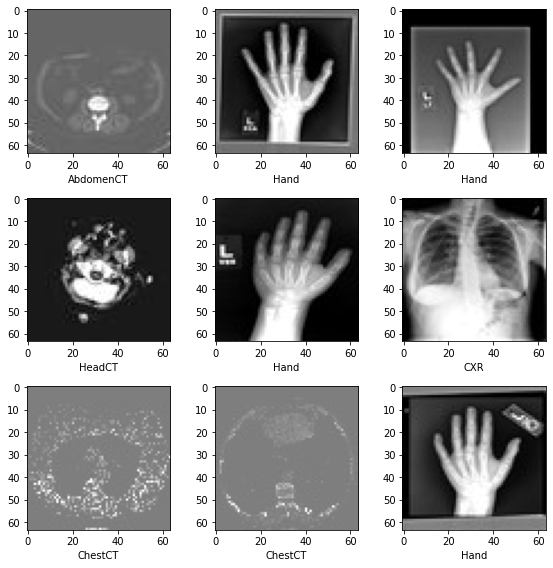

In [ ]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [ ]:
val_frac = 0.1
test_frac = 0.1
length = len(image_files_list)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]
test_x = [image_files_list[i] for i in test_indices]
test_y = [image_class[i] for i in test_indices]

print(
    f"Training count: {len(train_x)}, Validation count: "
    f"{len(val_x)}, Test count: {len(test_x)}")


Training count: 47164, Validation count: 5895, Test count: 5895


In [ ]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        EnsureType(),
    ]
)
val_transforms = Compose(
    [LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])

y_pred_trans = Compose([EnsureType(), Activations(softmax=True)])
y_trans = Compose([EnsureType(), AsDiscrete(to_onehot=num_class)])

In [ ]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)


val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=64, num_workers=2)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=64, num_workers=2)

In [ ]:
for x, y in train_loader:
  break

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DenseNet121(spatial_dims=2, in_channels=1,out_channels=num_class).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

In [ ]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []


for epoch in range(max_epochs):
  print(f"epoch {epoch + 1}/{max_epochs}")
  model.train();
  epoch_loss = 0
  step = 0
  for batch_data in tqdm(train_loader):
    step += 1 
    inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    # print(
    #         f"{step}/{len(train_ds) // train_loader.batch_size}, "
    #         f"train_loss: {loss.item():.4f}")
    epoch_len = len(train_ds) // train_loader.batch_size
  epoch_loss /= step
  epoch_loss_values.append(epoch_loss)
  print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

  if (epoch+1) % val_interval == 0:
    model.eval();
    with torch.no_grad():
      y_pred = torch.tensor([], dtype = torch.float32, device = device)
      y = torch.tensor([], dtype = torch.long, device = device)

      for val_data in tqdm(val_loader):
        val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
        y_pred = torch.cat([y_pred, model(val_images)], dim=0)
        y = torch.cat([y, val_labels], dim=0)
        y_onehot = [y_trans(i) for i in decollate_batch(y)]
        y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
        auc_metric(y_pred_act, y_onehot)
        result = auc_metric.aggregate()
        auc_metric.reset()
      del y_pred_act, y_onehot
      metric_values.append(result)
      acc_value = torch.eq(y_pred.argmax(dim=1), y)
      acc_metric = acc_value.sum().item() / len(acc_value)
      if result > best_metric:
              best_metric = result
              best_metric_epoch = epoch + 1
              torch.save(model.state_dict(), os.path.join(
                  root_dir, "best_metric_model.pth"))
              print("saved new best metric model")
      print(
          f"current epoch: {epoch + 1} current AUC: {result:.4f}"
          f" current accuracy: {acc_metric:.4f}"
          f" best AUC: {best_metric:.4f}"
          f" at epoch: {best_metric_epoch}"
      )


print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")







  






epoch 1/4


  0%|          | 0/737 [00:00<?, ?it/s]

epoch 1 average loss: 0.0185
saved new best metric model
current epoch: 1 current AUC: 1.0000 current accuracy: 0.9983 best AUC: 1.0000 at epoch: 1
epoch 2/4


  0%|          | 0/737 [00:00<?, ?it/s]

epoch 2 average loss: 0.0112
saved new best metric model
current epoch: 2 current AUC: 1.0000 current accuracy: 0.9992 best AUC: 1.0000 at epoch: 2
epoch 3/4


  0%|          | 0/737 [00:00<?, ?it/s]

epoch 3 average loss: 0.0082
current epoch: 3 current AUC: 1.0000 current accuracy: 0.9995 best AUC: 1.0000 at epoch: 2
epoch 4/4


  0%|          | 0/737 [00:00<?, ?it/s]

epoch 4 average loss: 0.0052
current epoch: 4 current AUC: 1.0000 current accuracy: 0.9993 best AUC: 1.0000 at epoch: 2
train completed, best_metric: 1.0000 at epoch: 2


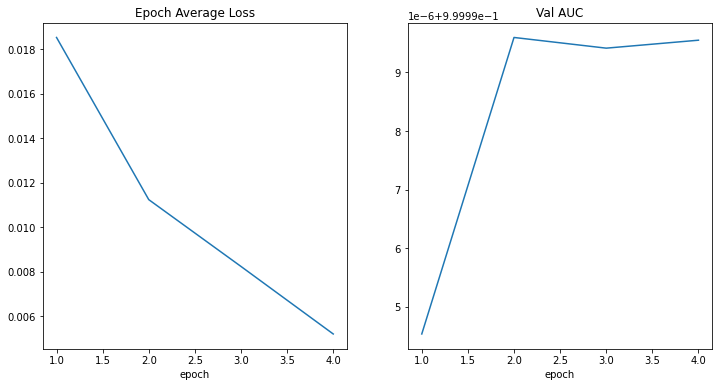

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()


In [ ]:
acc = 0
for x,y in test_loader:
  x = x.to(device)
  y = y.to(device)
  y_pred = model(x)
  acc += np.mean((y == torch.argmax(y_pred, axis = 1)).to("cpu").numpy())
acc = acc/len(test_loader)

print(acc)

0.9996639784946236
